In [3]:
import pandas as pd  # Data handling
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns  # Advanced plotting

In [25]:
# -------------------------------
# Load Datasets
# -------------------------------
# Define dataset file paths
dataset_path_CF = r"C:\Users\Randy\OneDrive\Documents\Desktop\Data Mining\DataSets\Finmark\Customer_Feedback_Data.csv"
dataset_path_PO = r"C:\Users\Randy\OneDrive\Documents\Desktop\Data Mining\DataSets\Finmark\Product_Offering_Data.csv"
dataset_path_TD = r"C:\Users\Randy\OneDrive\Documents\Desktop\Data Mining\DataSets\Finmark\Transaction_Data.csv"


In [27]:
# Read CSV files into pandas DataFrames
df_CF = pd.read_csv(dataset_path_CF)  # Customer Feedback Data
df_PO = pd.read_csv(dataset_path_PO)  # Product Offering Data
df_TD = pd.read_csv(dataset_path_TD)  # Transaction Data

In [29]:
# -------------------------------
# Data Exploration
# -------------------------------
# Display structure and missing values
print("Customer Feedback Data Summary:\n", df_CF.info())
print("\nProduct Offering Data Summary:\n", df_PO.info())
print("\nTransaction Data Summary:\n", df_TD.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_ID              5050 non-null   int64  
 1   Satisfaction_Score       4949 non-null   float64
 2   Feedback_Comments        5050 non-null   object 
 3   Likelihood_to_Recommend  5050 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 157.9+ KB
Customer Feedback Data Summary:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product_ID           15 non-null     int64  
 1   Product_Name         15 non-null     object 
 2   Product_Type         15 non-null     object 
 3   Risk_Level           15 non-null     object 
 4   Target_Age_Group     0 non-null      float64
 5   Target_Inco

In [31]:
# -------------------------------
# Data Preprocessing & Cleaning
# -------------------------------

# Remove invalid satisfaction scores (valid range: 1-10)
if "Satisfaction_Score" in df_CF.columns:
    df_CF = df_CF[df_CF["Satisfaction_Score"].between(1, 10)]

# Handle missing values by replacing NaNs with appropriate values
df_CF.fillna({'Satisfaction_Score': df_CF['Satisfaction_Score'].median()}, inplace=True)
df_TD.fillna({'Transaction_Amount': df_TD['Transaction_Amount'].median()}, inplace=True)

# Remove outliers in Transaction Amount using IQR (Interquartile Range)
if "Transaction_Amount" in df_TD.columns:
    q1, q3 = df_TD["Transaction_Amount"].quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    df_TD = df_TD[df_TD["Transaction_Amount"] <= upper_bound]


In [33]:
# -------------------------------
# Feature Engineering: Creating New Features
# -------------------------------

# 1. Categorizing Satisfaction Scores
def satisfaction_category(score):
    """Assigns a category to satisfaction scores."""
    if score <= 4:
        return 'Low'
    elif 5 <= score <= 7:
        return 'Medium'
    else:
        return 'High'

df_CF["Satisfaction_Category"] = df_CF["Satisfaction_Score"].apply(satisfaction_category)

# 2. Aggregating Total Spend per Customer
if "Customer_ID" in df_CF.columns and "Customer_ID" in df_TD.columns:
    total_spent = df_TD.groupby("Customer_ID")["Transaction_Amount"].sum().reset_index()
    total_spent.rename(columns={"Transaction_Amount": "Total_Spent"}, inplace=True)
    df_CF = df_CF.merge(total_spent, on="Customer_ID", how="left")

# 3. Computing Average Transaction Value
df_CF["Average_Transaction_Value"] = df_CF["Total_Spent"] / df_TD.groupby("Customer_ID")["Transaction_Amount"].count().reset_index(drop=True)

# 4. Classifying Customers Based on Tenure
if "Transaction_Date" in df_TD.columns:
    df_TD["Transaction_Date"] = pd.to_datetime(df_TD["Transaction_Date"])
    df_CF["Customer_Tenure"] = df_TD.groupby("Customer_ID")["Transaction_Date"].min().apply(lambda x: 'New' if x.year >= 2023 else 'Regular' if x.year >= 2020 else 'Long-term')

# 5. Purchase Frequency
purchase_freq = df_TD.groupby("Customer_ID")["Transaction_Amount"].count().reset_index()
purchase_freq.rename(columns={"Transaction_Amount": "Purchase_Frequency"}, inplace=True)
df_CF = df_CF.merge(purchase_freq, on="Customer_ID", how="left")

# 6. Calculating a Loyalty Score
df_CF["Loyalty_Score"] = (df_CF["Total_Spent"] * 0.5) + (df_CF["Purchase_Frequency"] * 0.3) + (df_CF["Satisfaction_Score"] * 0.2)


In [35]:
# -------------------------------
# Saving Processed Data
# -------------------------------
df_CF.to_csv("Processed_Customer_Feedback.csv", index=False)
df_PO.to_csv("Processed_Product_Offering.csv", index=False)
df_TD.to_csv("Processed_Transaction_Data.csv", index=False)
print("✅ Processed datasets saved successfully!")


✅ Processed datasets saved successfully!


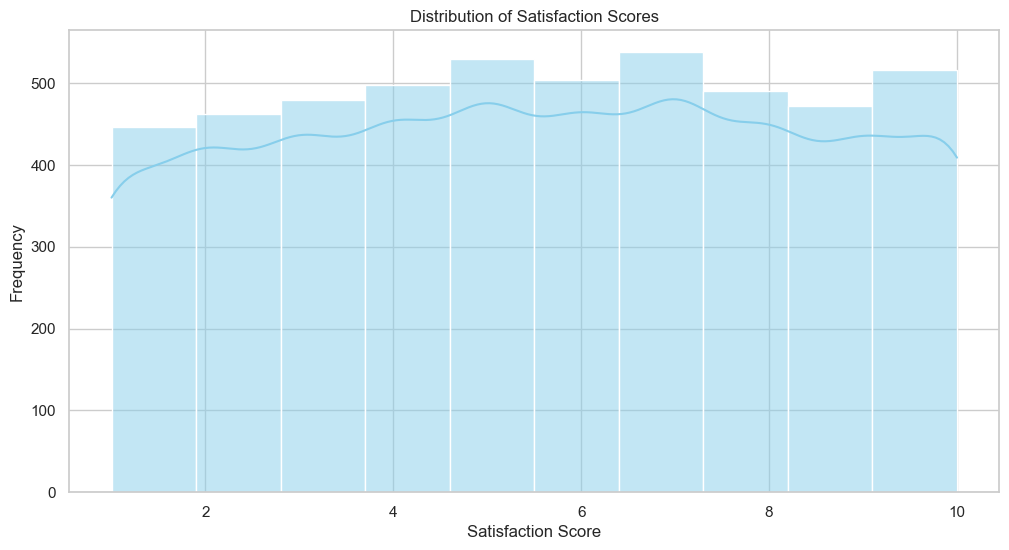

In [37]:
# -------------------------------
# Data Visualization
# -------------------------------

sns.set(style="whitegrid")

# 1. Distribution of Satisfaction Scores
plt.figure(figsize=(12, 6))
sns.histplot(df_CF['Satisfaction_Score'], kde=True, color='skyblue', bins=10)
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.show()

C:\Users\Randy\AppData\Local\Temp\ipykernel_12800\3321161900.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Satisfaction_Category', data=df_CF, order=['Low', 'Medium', 'High'], palette='Set3')


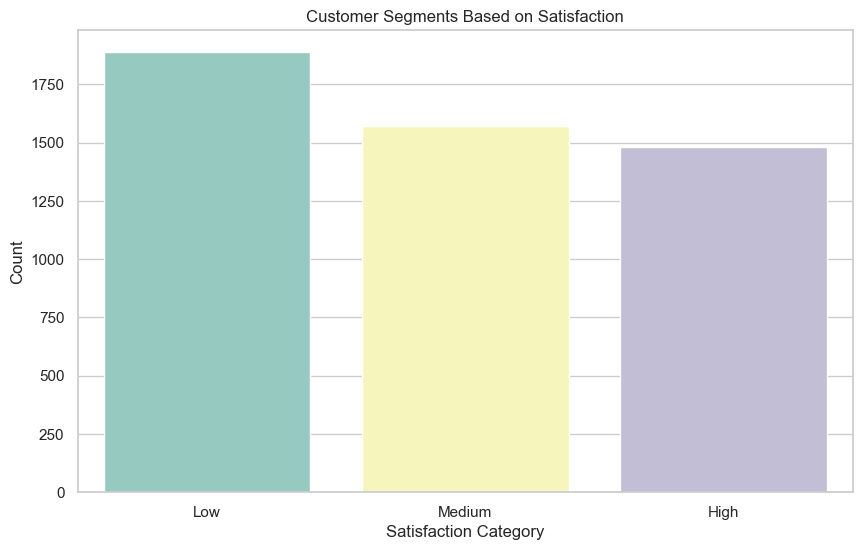

In [39]:
# 2. Customer Segments Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='Satisfaction_Category', data=df_CF, order=['Low', 'Medium', 'High'], palette='Set3')
plt.title('Customer Segments Based on Satisfaction')
plt.xlabel('Satisfaction Category')
plt.ylabel('Count')
plt.show()


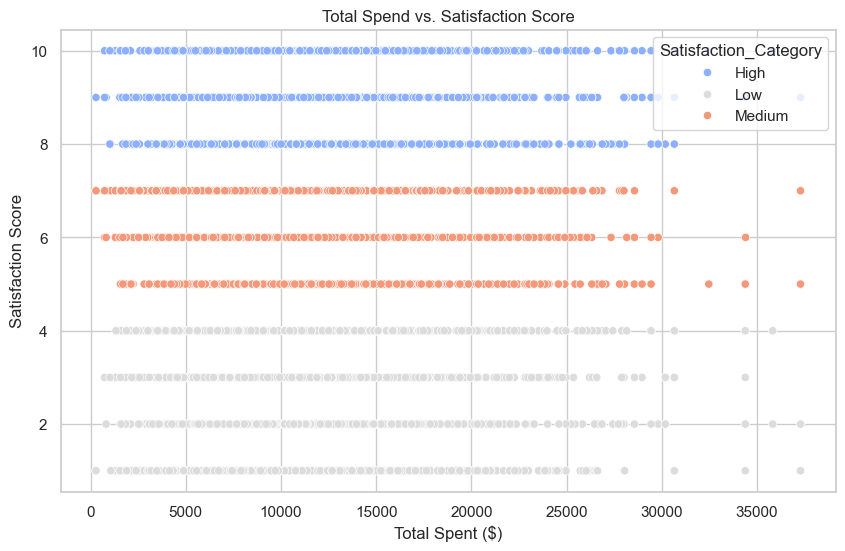

🎉 Data Preprocessing, Feature Engineering & Visualization Completed!


In [43]:
# 3. Relationship between Total Spent & Satisfaction Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_CF["Total_Spent"], y=df_CF["Satisfaction_Score"], hue=df_CF["Satisfaction_Category"], palette='coolwarm')
plt.title("Total Spend vs. Satisfaction Score")
plt.xlabel("Total Spent ($)")
plt.ylabel("Satisfaction Score")
plt.show()

# -------------------------------
# Final Message
# -------------------------------
print("🎉 Data Preprocessing, Feature Engineering & Visualization Completed!")